# 영화 추천 시스템

# 
# 
## 1. Demographic Filtering (인구 통계학적 필터링)

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [309]:
df1 = pd.read_csv("tmdb_5000_credits.csv")
df2 = pd.read_csv("tmdb_5000_movies.csv")

In [310]:
df1.shape, df2.shape

((4803, 4), (4803, 20))

- **영화 배우, 제목 출연진 등**

In [311]:
df1.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [312]:
df1.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

# 
- **영화 장르, 제작비, 키워드, 평점 등 정보**

In [313]:
df2.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [314]:
df2.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

- **df join**

In [315]:
df1.movie_id.equals(df2.id)

True

In [316]:
df1.columns = ['id', 'title', 'cast', 'crew']
df1_1 = df1[['id', 'cast', 'crew']]

In [317]:
df = df1_1.merge(df2, on = 'id')

In [318]:
df.shape, df.columns

((4803, 22),
 Index(['id', 'cast', 'crew', 'budget', 'genres', 'homepage', 'keywords',
        'original_language', 'original_title', 'overview', 'popularity',
        'production_companies', 'production_countries', 'release_date',
        'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
        'vote_average', 'vote_count'],
       dtype='object'))

# 
# 
만약, 

영화 1 : 영화 평점이 10/10 => 5명이 평가

영화 2: 영화 평점이 5/10 => 500명이 평가

영화 2 평점의 신뢰도가 영화 1 보다 높음

# 
<img src = "https://image.ibb.co/jYWZp9/wr.png">

- v : 영화에 대한 투표 수
- m : 차트에 나열되는 데 필요한 최소 투표수
- R : 전체 영화의 평균 등급
- C : 전체 영화의 평균 평점

In [319]:
C = df.vote_average.mean()
C

6.092171559442016

- **투표수의 상위 10% 값**

In [320]:
m = df.vote_count.quantile(0.9)
m

1838.4000000000015

# 
# 
- 투표 수가 m이상인 데이터 

In [321]:
q_movies = df.copy().loc[df.vote_count >= m]
q_movies.shape

(481, 22)

In [322]:
def weighted_rating(x, m=m,C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

In [323]:
q_movies['score'] = q_movies.apply(weighted_rating, axis = 1)

In [324]:
q_movies.shape

(481, 23)

In [325]:
score = q_movies.sort_values('score', ascending = False)

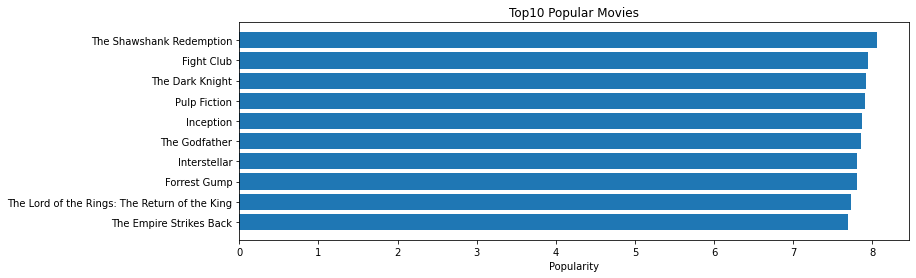

In [326]:
plt.figure(figsize = (12, 4))

plt.barh(score.title.head(10), score.score.head(10), align = 'center')
plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.title("Top10 Popular Movies")

plt.show()

In [327]:
pop = q_movies.sort_values('popularity', ascending = False)

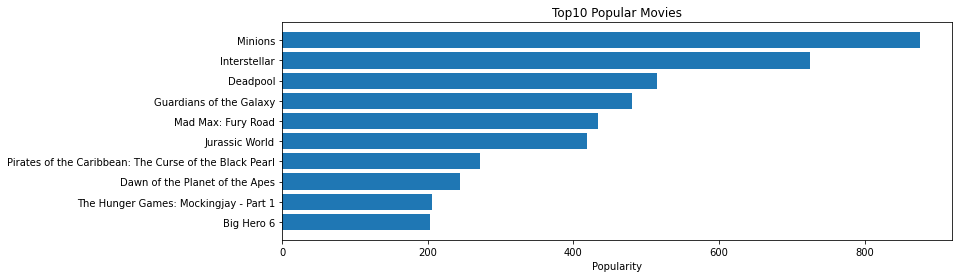

In [328]:
plt.figure(figsize = (12, 4))

plt.barh(pop.title.head(10), pop.popularity.head(10), align = 'center')
plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.title("Top10 Popular Movies")

plt.show()

# 
# 
# 
# 
## 2. Content Based Filtering (컨텐츠 기반 필터링)
- 특정 item에 기반한 유사 item 추천 
- **영화의 내용(개요, 출연진, 제작진, 키워드, 태그라인 등)은 다른 영화와의 유사성을 찾는 데 사용. 그런 다음 가장 유사할 가능성이 높은 영화를 추천**

<img src = "https://image.ibb.co/f6mDXU/conten.png">

1. 줄거리 설명을 기반으로 모든 영화에 대한 쌍별 유사성 점수를 계산
2. 유사성 점수를 기반으로 영화를 추천

# 

#### 장점
    - 많은 수의 사용자를 대상으로 쉽게 확장 가능
    - 사용자가 관심을 갖지 않던 상품 추천 가능
#### 단점
    - 입력 특성을 직접 설계해야 하기 때문에 많은 도메인 지식이 필요
    - 사용자의 기존 관심사항을 기반으로만 추천 가능

# 
# 
## 2-1. 줄거리 기반 필터링

# 
### 결측값 확인

In [329]:
df.overview.head(3)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
Name: overview, dtype: object

In [330]:
np.sum(df.overview.isnull())

3

In [331]:
df.overview = df.overview.fillna(' ')

In [332]:
np.sum(df.overview.isnull())

0

# 
# 
### BOW (Bag Of Words) 벡터화

In [333]:
import sklearn

- **코사인 유사도를 구하기 위하여 CountVectorizer가 아닌 TfidfVectorizer을 사용**
- **문장 별 자주 사용되지 않은 단어에 높은 값을 부여함에 따라, 유사도 분석에 용이**

In [334]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [335]:
tfidf = TfidfVectorizer(stop_words = 'english')

In [336]:
tfidf_matrix = tfidf.fit_transform(df.overview)
tfidf_matrix.shape

(4803, 20978)

# 
### 코사인 유사도
- 코사인 유사도를 사용하여 두 영화 간의 유사성을 나타내는 숫자 수량을 계산
- 코사인 유사도 점수는 크기와 무관하고 계산이 비교적 쉽고 빠르기 때문에 사용
- **TF-IDF 벡터라이저를 사용했기 때문에 내적을 계산하면 코사인 유사도**

### ```sklearn.metrics.pairwise.linear_kernel(a, b)```

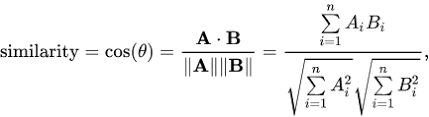

In [337]:
from sklearn.metrics.pairwise import linear_kernel

In [338]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [339]:
cosine_sim.shape

(4803, 4803)

In [340]:
indices = pd.Series(df.index, index=df.title).drop_duplicates()
indices.head()

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
The Dark Knight Rises                       3
John Carter                                 4
dtype: int64

# 
### 영화의 제목을 입력받으면, 코사인 유사도를 통해서 가장 유사도가 높은 상위 10개 영화 목록 반환

In [341]:
cosine_sim_df = pd.DataFrame(cosine_sim)

In [342]:
cosine_sim_df.index = df.title
cosine_sim_df.columns = df.title

In [343]:
cosine_sim_df.loc['Avatar'].sort_values(ascending = False).head(11).iloc[1:11]

title
Apollo 18                       0.186810
The American                    0.170151
The Matrix                      0.132307
The Inhabited Island            0.123933
Tears of the Sun                0.122490
Hanna                           0.104699
The Adventures of Pluto Nash    0.100914
Semi-Pro                        0.097996
Supernova                       0.094479
Blood and Chocolate             0.093139
Name: Avatar, dtype: float64

In [344]:
def get_recommendations(title, cosine_sim=cosine_sim):
    cosine_sim_df = pd.DataFrame(cosine_sim)
    cosine_sim_df.index = df.title
    cosine_sim_df.columns = df.title
    
    return indices[cosine_sim_df.loc[title].sort_values(ascending = False). \
                       head(11).iloc[1:11].index]

In [345]:
get_recommendations("The Avengers")

title
Avengers: Age of Ultron               7
Plastic                            3144
Timecop                            1715
This Thing of Ours                 4124
Thank You for Smoking              3311
The Corruptor                      3033
Wall Street: Money Never Sleeps     588
Team America: World Police         2136
The Fountain                       1468
Snowpiercer                        1286
dtype: int64

# 
# 
## 2-2. 배우, 감독 등 기반 필터링

### 감독 정보 추출 
- **현재 df의 'genres'열은 딕셔너리 형태가 ' '로 감싸진 문자열 형태**

In [346]:
df.loc[0, 'genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [347]:
type(df.loc[0, 'genres'])

str

### ```ast.literal_eval()``` : 문자열을 ' '을 벗겨, 형태 변경

In [348]:
from ast import literal_eval

In [349]:
features = ['cast', 'crew', 'keywords', 'genres']

for feature in features:
    df[feature] = df[feature].apply(literal_eval)

In [350]:
df.crew.head(3)

0    [{'credit_id': '52fe48009251416c750aca23', 'de...
1    [{'credit_id': '52fe4232c3a36847f800b579', 'de...
2    [{'credit_id': '54805967c3a36829b5002c41', 'de...
Name: crew, dtype: object

# 
- **crew열에는 'DIrector', 'Original Music Composer'등 다양한 직책들에 대한 정보가 포함 => 현재 필요한건 감독 (director)정보**
- **이에 따라 crew열에서 director에 대한 정보만 추출**

In [351]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [352]:
df['director'] = df['crew'].apply(get_director)

In [353]:
df.director.head(3)

0     James Cameron
1    Gore Verbinski
2        Sam Mendes
Name: director, dtype: object

In [354]:
np.sum(df.director.isnull()), np.sum(df.crew.isnull())

(30, 0)

# 
# 
### cast, keywords, genres  정보 추출

In [355]:
df.cast.head(1)

0    [{'cast_id': 242, 'character': 'Jake Sully', '...
Name: cast, dtype: object

In [356]:
df.keywords.head(1)

0    [{'id': 1463, 'name': 'culture clash'}, {'id':...
Name: keywords, dtype: object

In [357]:
df.genres.head(1)

0    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
Name: genres, dtype: object

- **cast열에는 주연 배우와 다양한 조연 배우들 정보가 포함**
- **이에 따라 cast열에서 표기되는 상위 3명의 배우 이름 (name)만 추출**
- **keywords와 genres열에서도 상위 3개의 name만 추출**

In [358]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names
    return []

In [359]:
features = ['cast', 'keywords', 'genres']

In [360]:
for feature in features:
    df[feature] = df[feature].apply(get_list)

In [361]:
df[['title', 'director', 'cast', 'keywords', 'genres']].head(3)

,title,director,cast,keywords,genres
0,Avatar,James Cameron,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,Gore Verbinski,"[Johnny Depp, Orlando Bloom, Keira Knightley]","[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,Sam Mendes,"[Daniel Craig, Christoph Waltz, Léa Seydoux]","[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


# 
- **대문자와 소문자는 다른 객체로 인식 => 모든 대문자를 소문자로 변환**
- **띄어쓰기 제거**

In [362]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(' ', '')) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(' ', ''))
        else:
            return ''

In [363]:
features = ['director', 'cast', 'keywords', 'genres']
for feature in features:
    df[feature] = df[feature].apply(clean_data)

In [364]:
df[['title', 'director', 'cast', 'keywords', 'genres']].head(3)

,title,director,cast,keywords,genres
0,Avatar,jamescameron,"[samworthington, zoesaldana, sigourneyweaver]","[cultureclash, future, spacewar]","[action, adventure, fantasy]"
1,Pirates of the Caribbean: At World's End,goreverbinski,"[johnnydepp, orlandobloom, keiraknightley]","[ocean, drugabuse, exoticisland]","[adventure, fantasy, action]"
2,Spectre,sammendes,"[danielcraig, christophwaltz, léaseydoux]","[spy, basedonnovel, secretagent]","[action, adventure, crime]"


# 
# 
### BOW (Bag Of Words) 벡터화

- **추출한 정보들을 하나의 문자열로 결합**

In [369]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + \
    ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [370]:
df['soup'] = df.apply(create_soup, axis = 1)
df['soup'].head(3)

0    cultureclash future spacewar samworthington zo...
1    ocean drugabuse exoticisland johnnydepp orland...
2    spy basedonnovel secretagent danielcraig chris...
Name: soup, dtype: object

In [371]:
count = CountVectorizer(stop_words='english')
count_matrix = vect.fit_transform(df.soup)
count_matrix.shape

(4803, 11520)

# 
### 코사인 유사도
### ```sklearn.metrics.pairwise.cosine_similarity(a, b)``` 

In [374]:
from sklearn.metrics.pairwise import cosine_similarity

In [375]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# 
### 영화의 제목을 입력받으면, 코사인 유사도를 통해서 가장 유사도가 높은 상위 10개 영화 목록 반환

In [381]:
def get_recommendations(title, cosine_sim=cosine_sim):
    cosine_sim_df2 = pd.DataFrame(cosine_sim2)
    cosine_sim_df2.index = df.title
    cosine_sim_df2.columns = df.title
    
    return indices[cosine_sim_df2.loc[title].sort_values(ascending = False). \
                       head(11).iloc[1:11].index]

In [383]:
get_recommendations("Up")

title
Monsters, Inc.                                        231
Alpha and Omega: The Legend of the Saw Tooth Cave    3403
Meet the Deedles                                     1983
Elsa & Fred                                          3114
The Nut Job                                          1580
Running Forever                                      3670
A Charlie Brown Christmas                            4709
Barnyard                                              896
Hoodwinked!                                          2396
Free Birds                                            837
dtype: int64